PARTE 1. Análisis Exploratorio e Ingeniería de Características


In [1]:
#LIBRERIAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

#Cargar el archivo
df = pd.read_excel("Viajes Mayo BAT (1).xlsx")

print(df.shape)
df.head()



(163798, 22)


,Date,AssetName,AssetExtra,AssetName2,AssetExtra2,SiteName,SiteName2,TrailerInfo,ActivityStartDateTime,ActivityEndDateTime,...,TotalStandingTime,TotalDuration,TotalIdleTime,ParkingTime,StartOdometer,EndOdometer,TotalDistanceTravelled,TotalEngineSeconds,AverageSpeed,MaxSpeed
0,2025-05-02,XCU-35G_Honda_Wave_110S_2024,XCU35G,"Hernandez Calle, Andrea Del Carmen",1105687687,BOGOTA / BACK UP BOGOTA,BOGOTA / YUBER GARZON,MOTOCICLETA,07:26:58,07:35:27,...,00:08:29,00:08:29,00:00:00,1900-01-01 07:26:58,38852.84,38852.84,0.00,00:00:00,0.00,0
1,2025-05-02,XCU-35G_Honda_Wave_110S_2024,XCU35G,"Hernandez Calle, Andrea Del Carmen",1105687687,BOGOTA / BACK UP BOGOTA,BOGOTA / YUBER GARZON,MOTOCICLETA,08:01:18,08:13:22,...,00:00:00,00:12:04,00:00:00,00:25:51,38852.84,38857.63,4.79,00:00:00,23.80,54
2,2025-05-02,XCU-35G_Honda_Wave_110S_2024,XCU35G,"Hernandez Calle, Andrea Del Carmen",1105687687,BOGOTA / BACK UP BOGOTA,BOGOTA / YUBER GARZON,MOTOCICLETA,08:32:08,08:32:58,...,00:00:50,00:00:50,00:00:00,00:18:46,38857.63,38857.63,0.00,00:00:00,0.00,0
3,2025-05-02,XCU-35G_Honda_Wave_110S_2024,XCU35G,"Hernandez Calle, Andrea Del Carmen",1105687687,BOGOTA / BACK UP BOGOTA,BOGOTA / YUBER GARZON,MOTOCICLETA,08:48:04,08:48:53,...,00:00:49,00:00:49,00:00:00,00:15:06,38857.63,38857.63,0.00,00:00:00,0.00,0
4,2025-05-02,XCU-35G_Honda_Wave_110S_2024,XCU35G,"Hernandez Calle, Andrea Del Carmen",1105687687,BOGOTA / BACK UP BOGOTA,BOGOTA / YUBER GARZON,MOTOCICLETA,09:03:24,09:07:18,...,00:00:00,00:03:54,00:00:00,00:14:31,38857.63,38858.07,0.44,00:00:00,6.78,18


In [5]:
# Limpieza de datos


# Eliminar columnas 
cols_to_drop = [ "rso", "AssetExtra", "AssetExtra2", "TrailerInfo", "BatteryEnd"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Ajuste de las variables de tiempo
for col in ["TotalDrivingTime", "TotalStandingTime", "TotalIdleTime", "ParkingTime"]:
    if col in df.columns:
        df[col] = pd.to_timedelta(df[col].astype(str), errors='coerce')

df["driving_minutes"] = df["TotalDrivingTime"].dt.total_seconds() / 60
df["idle_minutes"] = df["TotalIdleTime"].dt.total_seconds() / 60
df["parking_minutes"] = df["ParkingTime"].dt.total_seconds() / 60

        AverageSpeed       MaxSpeed  TotalDistanceTravelled
count  163798.000000  163798.000000           163798.000000
mean       10.223722      29.863405                2.066866
std         8.932838      17.548992                7.226027
min         0.000000       0.000000                0.000000
25%         4.530000      18.000000                0.100000
50%         8.470000      27.000000                0.280000
75%        13.850000      40.000000                1.090000
max       678.000000     678.000000              883.720000


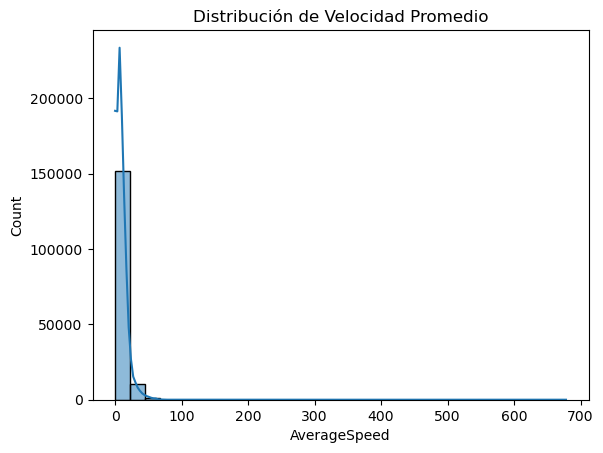

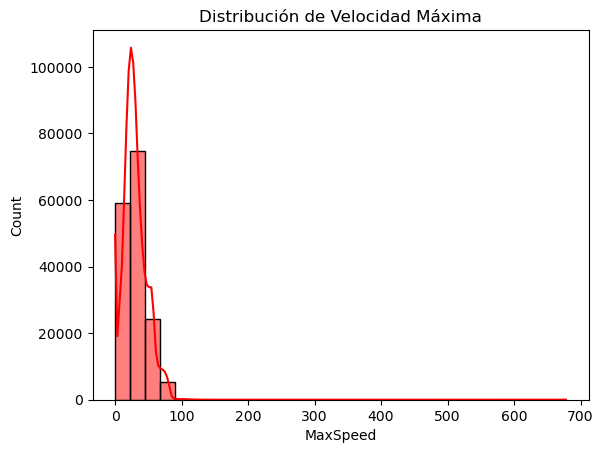

In [6]:
#### Exploracion


print(df[["AverageSpeed", "MaxSpeed", "TotalDistanceTravelled"]].describe())

# Plots velocidad
sns.histplot(df["AverageSpeed"], bins=30, kde=True)
plt.title("Distribución de Velocidad Promedio")
plt.show()

sns.histplot(df["MaxSpeed"], bins=30, kde=True, color="red")
plt.title("Distribución de Velocidad Máxima")
plt.show()


In [ ]:
# Nuevas Variables

df["Total_distance"] = df["TotalDistanceTravelled"]
df["Speed"] = df["Total_distance"] / (df["driving_minutes"] / 60 + 0.01)  

# Velocidad esperada según distancia/tiempo
df["expected_speed"] = df["TotalDistanceTravelled"] / (df["TotalDrivingTime"].dt.total_seconds() / 3600 + 1e-3)

# Diferencia entre velocidad máxima y promedio (indicador de brusquedad)
df["speed_spike"] = df["MaxSpeed"] - df["AverageSpeed"]

# Proxy de aceleración media (sin GPS detallado)
df["accel_proxy"] = df["speed_spike"] / (df["TotalDrivingTime"].dt.total_seconds() / 60 + 1e-3)

# Magnitud de eventos bruscos (percentil 95 de la diferencia relativa)
spike_95 = df["speed_spike"].quantile(0.95)
df["hard_event_flag"] = (df["speed_spike"] > spike_95).astype(int)

# Conteo total de eventos bruscos
df["hard_event_count"] = df.groupby("AssetName2")["hard_event_flag"].transform("sum")

# Proporción de exceso de velocidad (>80 km/h)
df["high_speed_ratio"] = np.where(df["MaxSpeed"] > 80, 1, 0)

# Perfil de velocidad
df["cruise_ratio"] = np.where((df["AverageSpeed"] >= 40) & (df["AverageSpeed"] <= 60), 1, 0)
df["low_speed_ratio"] = np.where(df["AverageSpeed"] < 20, 1, 0)

# Volatilidad de velocidad (proxy)
df["speed_volatility"] = (df["MaxSpeed"] - df["AverageSpeed"]) / (df["AverageSpeed"] + 1)

# Viajes largos = más exposición al riesgo
df["trip_duration_min"] = df["TotalDrivingTime"].dt.total_seconds() / 60
df["long_trip"] = (df["trip_duration_min"] > df["trip_duration_min"].median()).astype(int)


# Suavidad (relación entre velocidad promedio y máxima)
df["smoothness_index"] = df["AverageSpeed"] / (df["MaxSpeed"] + 1)

# Ratio de conducción activa (conducción / total)
df["active_ratio"] = df["TotalDrivingTime"].dt.total_seconds() / (
    df["TotalDrivingTime"].dt.total_seconds() + 
    df["TotalIdleTime"].dt.total_seconds() + 1
)

# Sinuosidad proxy: viajes con mucha variación entre velocidades
df["curvy_trip_flag"] = (df["speed_volatility"] > df["speed_volatility"].quantile(0.8)).astype(int)




# Creacion Variable Objetivo

df["is_risky_trip"] = (
    (df["high_speed_ratio"] == 1) |
    (df["curvy_trip_flag"] == 1) |
    (df["hard_event_flag"] == 1)
).astype(int)

####### Data final

cols_model = [
    "AssetName2", "Date", "AverageSpeed", "MaxSpeed", "Total_distance",
    "speed_spike", "accel_proxy", "speed_volatility", "smoothness_index",
    "high_speed_ratio", "cruise_ratio",
    "idle_minutes", "driving_minutes","is_risky_trip"
]

df_model = df[cols_model]
df_model.to_csv("driver_behavior_features.csv", index=False)
print(df_model)
print(df["is_risky_trip"])


                                AssetName2       Date  AverageSpeed  MaxSpeed  \
0       Hernandez Calle, Andrea Del Carmen 2025-05-02          0.00         0   
1       Hernandez Calle, Andrea Del Carmen 2025-05-02         23.80        54   
2       Hernandez Calle, Andrea Del Carmen 2025-05-02          0.00         0   
3       Hernandez Calle, Andrea Del Carmen 2025-05-02          0.00         0   
4       Hernandez Calle, Andrea Del Carmen 2025-05-02          6.78        18   
...                                    ...        ...           ...       ...   
163793                   Delgado, Leonardo 2025-05-16          8.30        35   
163794                   Delgado, Leonardo 2025-05-16         13.95        58   
163795                   Delgado, Leonardo 2025-05-16         23.90        57   
163796                   Delgado, Leonardo 2025-05-16          0.00         0   
163797                   Delgado, Leonardo 2025-05-16          0.00         0   

        Total_distance  spe

PARTE 2: Desarrollo del Modelo Predictivo ("Driver Score")

In [13]:
## importar librerias

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc,roc_auc_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
from supervised.automl import AutoML
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import imblearn
from sklearn.impute import SimpleImputer

In [24]:
##### Variable Objetivo y Covariables

target = 'is_risky_trip'

features = [
    'avg_speed','max_speed','speed_spike','accel_proxy','hard_event_flag',
    'hard_event_count_driver','high_speed_flag','cruise_flag','speed_volatility',
    'trip_duration_min','long_trip','smoothness_index',
    'active_ratio','curvy_trip_flag'
]

# Asegurar que las columnas existan en el DataFrame
features = [f for f in features if f in df_model.columns]
df_model_new = df_model[features + [target]].copy()
df_model_new.fillna(0, inplace=True)

X = df_model_new[features]
y = df_model_new[target]

In [33]:
############### BALANCE DE CLASES################3

filter_rows= df_model_new[df_model_new['is_risky_trip']==0]
drop_rows= filter_rows.sample(frac=0.60,random_state=1)
Final_TRAIN= df_model_new.drop(drop_rows.index)

X_1 = Final_TRAIN[features]
y_1 = Final_TRAIN[target]

In [37]:
#### División entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X_1, y_1, test_size=0.25, stratify=y_1, random_state=10
)

In [38]:
# Crear el imputador (usamos la mediana porque es robusta a valores extremos)
imputer = SimpleImputer(strategy="median")

# Ajustar en los datos de entrenamiento y transformar
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [28]:
# Crear el objeto SMOTE
sm = SMOTE(random_state=42)

# Aplicarlo solo en el conjunto de entrenamiento
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Antes del balanceo:", y_train.value_counts())
print("Después del balanceo:", y_res.value_counts())

Antes del balanceo: is_risky_trip
0    93205
1    29643
Name: count, dtype: int64
Después del balanceo: is_risky_trip
0    93205
1    93205
Name: count, dtype: int64


In [44]:
#### Configuracion del modelo

automl = AutoML(
    mode="Perform",
    ml_task="binary_classification",
    algorithms=["LightGBM", "Random Forest", "Xgboost", "CatBoost", "Neural Network"],
    eval_metric="accuracy",
    results_path="Filter_Model_2",
    total_time_limit=600,  # segundos (~10 minutos)
    random_state=10,
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 5,
        "shuffle": True
    }
)


In [45]:
# Entrenar
automl.fit(X_train, y_train)

AutoML directory: Filter_Model_2
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['LightGBM', 'Random Forest', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 5 models
1_Default_LightGBM accuracy 0.997355 trained in 149.2 seconds (1-sample predict time 0.0784 seconds)
2_Default_Xgboost accuracy 0.997086 trained in 168.6 seconds (1-sample predict time 0.4398 seconds)
* Step not_so_random will try to check up to 20 models
7_LightGBM not trained. Stop training after the first fold. Time needed to train on the first fold 102.0 seconds. The time estimate for training on all folds is larger than total_time_limit.
Skip g

,results_path,'Filter_Model_2'
,total_time_limit,600
,mode,'Perform'
,ml_task,'binary_classification'
,model_time_limit,None
,algorithms,"['LightGBM', 'Random Forest', ...]"
,train_ensemble,True
,stack_models,'auto'
,eval_metric,'accuracy'
,validation_strategy,"{'k_folds': 5, 'shuffle': True, 'validation_type': 'kfold'}"
,explain_level,'auto'


In [46]:
# Metricas del modelo

preds = automl.predict(X_test)
probs = automl.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, probs))
print("\nReporte de Clasificación:")
print(classification_report(y_test, preds))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, preds))

# ==========================
# 5. Guardar y explicar
# ==========================
automl.report()  # genera reporte HTML con explicaciones automáticas
automl.save("automl_driver_score.pkl")

print("\n✅ Modelo entrenado y guardado en 'automl_driver_score.pkl'")
print("📊 Revisa el reporte HTML en la carpeta 'automl_driver_score/'")

ROC-AUC: 0.9999899105112018

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12428
           1       1.00      0.99      1.00      9881

    accuracy                           1.00     22309
   macro avg       1.00      1.00      1.00     22309
weighted avg       1.00      1.00      1.00     22309


Matriz de Confusión:
[[12428     0]
 [   94  9787]]


AttributeError: 'AutoML' object has no attribute 'save'

In [ ]:
predictions = automl.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, predictions))
predictions_probability = automl.predict_proba(X_test)

Test accuracy: 0.9980952380952381
